In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

import diffoptics as optics

# Helpers

In [2]:
def gaussian_kernel_1d(size, sigma=1):
    x = torch.arange(-size/2, size/2, 1)
    return 1 / (sigma * np.sqrt(2 * np.pi)) * torch.exp(-.5 * (x / sigma)**2)

def gaussian_kernel_2d(size, sigma=1):
    return torch.outer(gaussian_kernel_1d(size, sigma=sigma),
                       gaussian_kernel_1d(size, sigma=sigma))

In [3]:
def make_scene(f=0.05, m=0.15, na=1 / 1.4, sensor_resolution=(9600, 9600), sensor_pixel_size=(3.76e-6, 3.76e-6),
               poisson_noise_mean=2, quantum_efficiency=0.8, psfs={}, psf_ratio=1):

    image_pof = -f * (1 + m)
    object_pof = f * (1 + m) / m

    # Sensor
    sensor = optics.Sensor(position=(image_pof, 0, 0), resolution=sensor_resolution, pixel_size=sensor_pixel_size,
                    poisson_noise_mean=poisson_noise_mean, quantum_efficiency=quantum_efficiency,
                    psfs=psfs, psf_ratio=psf_ratio)

    # Scene
    scene = optics.Scene(sensor)

    # Lens
    lens = optics.PerfectLens(f=f, m=m, na=na)
    scene.add_object(lens, is_lens=True)
    
    # Atom Cloud
    atom_cloud = optics.LightSourceFromDistribution(optics.AtomCloud(position=torch.tensor([object_pof, 0., 0.])))

    return scene, atom_cloud

In [4]:
def make_image(scene, atom_cloud, phi=0.1, device='cpu', nb_rays=int(1e9), batch_size=int(50e6),
               quantum_efficiency=True, add_poisson_noise=True, show_progress=True):

    with torch.no_grad():

        progress_bar = tqdm if show_progress else lambda x: x
        nb_rays_left_to_sample = nb_rays
        for _ in progress_bar(range(int(np.ceil(nb_rays / batch_size)))):
            rays = atom_cloud.sample_rays(min(batch_size, nb_rays_left_to_sample), device=device)
            rays.meta = {'depth' : rays.origins[:, 0]}
            optics.forward_ray_tracing(rays, scene, max_iterations=1, quantum_efficiency=quantum_efficiency)
            nb_rays_left_to_sample -= batch_size

        return scene.sensor.readout(add_poisson_noise=True)

# Toy gaussian Psfs

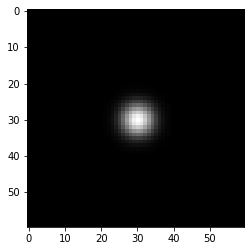

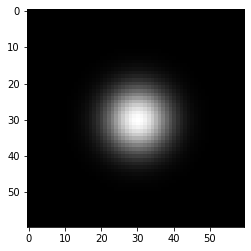

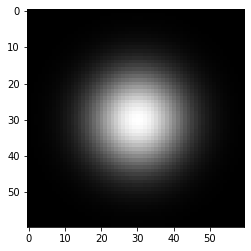

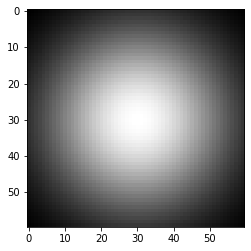

In [5]:
for sigma in [3, 6, 9, 18]:
    kernel = gaussian_kernel_2d(60, sigma=sigma)
    plt.imshow(kernel.numpy(), cmap='gray')
    plt.show()

# Image without Psf

In [6]:
calibration_camera = {'f': 0.025,
                      'm': 0.243,
                      'na': 1 / 1.4,
                      'quantum_efficiency': .75,
                      'poisson_noise_mean': 3,
                      'sensor_resolution': (3088, 3088),
                      'sensor_pixel_size': (2.4e-6, 2.4e-6),
                      'psfs': {}, 
                      'psf_ratio': 1#psf_ratio
                     }

scene, atom_cloud = make_scene(**calibration_camera)

img = make_image(scene, atom_cloud, device='cuda')

  0%|          | 0/20 [00:00<?, ?it/s]/sdf/home/s/s151486/.local/lib/python3.6/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
100%|██████████| 20/20 [00:55<00:00,  2.76s/it]


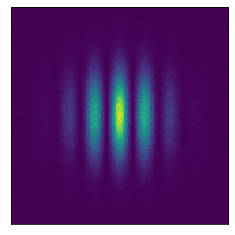

In [7]:
c = 3088
w = 80
plt.imshow(img.data.cpu().numpy()[c//2 - w:c//2+w, 
                                  c//2 - w:c//2+w])
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.show()

# Image with Psf

In [8]:
# 4D data structure
inf = 1e15
psfs = {'data' : {(-inf, inf) : {(0, 3088) : optics.PSF(gaussian_kernel_2d(45, sigma=3))}}}


In [9]:
calibration_camera = {'f': 0.025,
                      'm': 0.243,
                      'na': 1 / 1.4,
                      'quantum_efficiency': .75,
                      'poisson_noise_mean': 3,
                      'sensor_resolution': (3088, 3088),
                      'sensor_pixel_size': (2.4e-6, 2.4e-6),
                      'psfs': psfs, 
                      'psf_ratio': 1,
                     }

scene, atom_cloud = make_scene(**calibration_camera)

img = make_image(scene, atom_cloud, device='cuda')

100%|██████████| 20/20 [00:47<00:00,  2.36s/it]


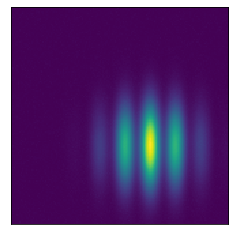

In [10]:
c = 3088
w = 80
plt.imshow(img.data.cpu().numpy()[c//2 - w:c//2+w, 
                                  c//2 - w:c//2+w])
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.show()